# Extract data from Json

In the previous notebook, we extracted all the page sources from madlan.co.il into 3 json files:
1. apartments for buying ("madlan_scraped_pages1.json")
2. apartments for renting ("madlan_scraped_pages2.json")
3. apartments united ("madlan_scraped_pages_all.json")

In this notebook, we are going to extract from all the page sources the json data it contains (in the page_source for each page)
Then, we are going to create a dataframe that extracts from the json files.

In [ ]:
import pandas as pd
import json

def extractJson(data):
    data=data.get("data")
    frames = []
    cnt_failed = 0
    for i in range(2):
        new_data = data[i]
        current_data = new_data.get("info")
        data_type = new_data.get("deal_type")
        print(f"Extracting {data_type} data...")

        for j in range(1,len(current_data)):
            page = ([entry for entry in current_data if entry["page"] == j][0])["source"] #return page source for page i
            start = page.find('"poi":[{"id":') + len('"poi":[') #index where json apartments data begins
            end = page.find('"insights"}}]') + len ('"insights"}}') #index where json apartments data end

            #converting json strimg to list of apartments:
            page = page[start:end].split(',{"id":"')
            page = str([apartment if apartment.startswith('{"id":"') else r';{"id":"'+apartment for apartment in page])
            page = page[2:-2].replace("\\'","'").replace('\\"','"').replace('\\\\','\\')
            page = page.split("\', \';")

            lst_page = []
            for x in range(len(page)):
                try:
                    lst_page.append(json.loads(page[x]))
                except:
                    cnt_failed+=1
                    pass
                    #page = [json.loads(page[x]) for x in range(len(page))]
            page = lst_page

            for apartment in page:
                frames.append(apartment)
        print(f"'{data_type}' data extracted successufly")
    print("corrupted data dropped: ",cnt_failed)
    return frames


def createMainTable(frames):
    df_main = pd.DataFrame(
        columns=["id", "lat", "lng", "create_date",
                 "address","floor","deal_type","beds",
                 "baths","price","size_m^2","condition"
                ]
    )

    for i in range(len(frames)):
        try:
            _id = frames[i].get("id")
            if _id == "itzhaki":
                continue
            lat = frames[i].get("locationPoint").get("lat")
            lng = frames[i].get("locationPoint").get("lng")
            create_date = pd.to_datetime(frames[i].get("firstTimeSeen")).strftime('%Y-%m-%d %H:%M:%S')
            address = frames[i].get("address")
            deal = frames[i].get("dealType")
            beds = frames[i].get("beds")
            floor = frames[i].get("floor")
            baths = frames[i].get("baths")
            price = frames[i].get("price")
            size = frames[i].get("area")
            condition = frames[i].get("generalCondition")
        except:
            pass

        apartment = pd.DataFrame(
            {
                "id": [_id],
                "lat": [lat],
                "lng": [lng],
                "create_date": [create_date],
                "address":[address],
                "floor":[floor],
                "deal_type":[deal],
                "beds":[beds],
                "baths":[baths],
                "price":[price],
                "size_m^2":[size],
                "condition":[condition],
                "url":"https://www.madlan.co.il/listings/"+_id
            }
        )
        df_main = pd.concat([df_main,apartment])

        #replacing values:
        dict_deals = {"unitBuy":"למכירה","unitRent":"להשכרה"}
        dict_condition = {
            "preserved":"שמור",
            "renovated":"משופץ",
            "asNew":"כמו חדש",
            "toRenovated":"ישן",
            "new":"חדש",
            None:"לא צוין"
        }
        df_main.replace({"deal_type":dict_deals,"condition":dict_condition},inplace=True)

        df_main = df_main[df_main['id'].str.match(r'^[a-zA-Z0-9]{11}$')]
        df_main.sort_values(by="create_date",inplace=True)

        #fixing data
        df_main.drop_duplicates(inplace=True)
        df_main.reset_index(inplace=True)
        del df_main["index"]

    return df_main


def createTagTable(frames):
    df_tags = pd.DataFrame(
        columns={"id":[],"tag_category":[],"tag_value":[]}
    )

    for i in range(len(frames)):
        _id = frames[i].get("id")
        if _id == "itzhaki":
            continue
        tags = frames[i].get("tags")

        if tags is None:
            continue

        keys = list(tags.keys())[:-1]
        values = list(tags.values())[:-1]
        ln_tags = len(keys)

        new_tags = pd.DataFrame(
            {
                "id":[_id for i in range(ln_tags)],
                "tag_category":keys,
                "tag_value":values
            }
        )
        df_tags = pd.concat([df_tags,new_tags])

        #fixing data
        df_tags = df_tags[df_tags["id"].str.match(r'^[a-zA-Z0-9]{11}$')]
        df_tags.drop_duplicates(inplace=True)
        df_tags.reset_index(inplace=True)
        del df_tags["index"]


        #replacing values:
        dict_tags = {
            "bestSchool":"דירוג בתי ספר",
            "bestSecular":"התאמה לחילונים",
            "bestReligious":"התאמה לדתיים",
            "safety":"ביטחון",
            "parkAccess":"קירבה לפארקים",
            "quietStreet":"רחוב שקט",
            "dogPark":"קירבה לפארק כלבים",
            "familyFriendly":"התאמה למשפחות"
        }
        df_tags["tag_category"].replace(dict_tags,inplace=True)[0]

    return df_tags


def createPictureTable(frames):
    df_images = pd.DataFrame(
        columns={"id":[],"image_url":[]}
    )

    for i in range(len(frames)):
        _id = frames[i].get("id")
        if _id == "itzhaki":
            continue
        images = frames[i].get("images")

        if len(images)==0:
            continue

        try:
            images = ["https://images2.madlan.co.il/t:nonce:v=2;resize:height=640;convert:type=webp"+item["imageUrl"] for item in images]
        except:
            images = ["https://images2.madlan.co.il/t:nonce:v=2;resize:height=640;convert:type=webp"+item["path"] for item in images]

        new_images = pd.DataFrame(
            {
                "id":[_id for i in range(len(images))],
                "image_url":images
            }
        )
        df_images = pd.concat([df_images,new_images])

        #fixing data
        df_images = df_images[df_images["id"].str.match(r'^[a-zA-Z0-9]{11}$')]
        df_images.drop_duplicates(inplace=True)
        df_images.reset_index(inplace=True)
        del df_images["index"]

    return df_images


def createInsightsTable(frames):
    df_insights = pd.DataFrame(
        columns={"id":[],"insight_category":[],"insight_value":[]}
    )

    for i in range(len(frames)):
        _id = frames[i].get("id")
        if _id == "itzhaki":
            continue
        insights_data = frames[i].get("insights")

        if insights_data is None:
            continue

        categories = [insight['category'] for insight in insights_data["insights"]]
        values = [insight['tradeoff']['value'] if insight['tradeoff'] else None for insight in insights_data["insights"]]

        new_insights = pd.DataFrame(
            {
                "id":[_id for i in range(len(categories))],
                "insight_category":categories,
                "insight_value":values
            }
        )
        df_insights = pd.concat([df_insights,new_insights])

        #fixing data
        df_insights = df_insights[df_insights["id"].str.match(r'^[a-zA-Z0-9]{11}$')]
        df_insights.drop_duplicates(inplace=True)
        df_insights.reset_index(inplace=True)
        del df_insights["index"]


        #replacing values:
#         dict_tags = {
#             "bestSchool":"דירוג בתי ספר",
#             "bestSecular":"התאמה לחילונים",
#             "bestReligious":"התאמה לדתיים",
#             "safety":"ביטחון",
#             "parkAccess":"קירבה לפארקים",
#             "quietStreet":"רחוב שקט",
#             "dogPark":"קירבה לפארק כלבים",
#             "familyFriendly":"התאמה למשפחות"
#         }
#         df_tags["tag_category"].replace(dict_tags,inplace=True)[0]

    return df_insights

In [ ]:
path = r"madlan_scraped_pages_all.json"
with open(path, 'r', encoding='utf-8-sig') as file:
    data = json.load(file)

Extracting buys data...
'buys' data extracted successufly
Extracting rents data...
'rents' data extracted successufly
corrupted data dropped:  88


#### Create a list of json items -> each item is an apartment description

In [ ]:
json_file = extractJson(data)

#preview of json
json_file[0]

{'id': 'gBxSkU3fU6h',
 'locationPoint': {'lat': 32.125493138693294,
  'lng': 34.80818419979825,
  '__typename': 'Point'},
 'type': 'bulletin',
 'firstTimeSeen': '2024-02-28T14:47:05.000Z',
 'addressDetails': {'docId': 'אלקחי-מרדכי-16-תל-אביב-יפו-ישראל',
  'city': 'תל אביב יפו',
  'borough': None,
  'zipcode': None,
  'streetName': 'אלקחי מרדכי',
  'neighbourhood': 'רמת אביב ג',
  'neighbourhoodDocId': 'שכונה-רמת-אביב-ג-תל-אביב-יפו-ישראל',
  'cityDocId': 'תל-אביב-יפו-ישראל',
  'resolutionPreferences': 'neighborhood',
  'streetNumber': '16',
  'unitNumber': None,
  'district': 'מחוז תל אביב',
  '__typename': 'Address'},
 'dealType': 'unitBuy',
 'address': 'אלקחי מרדכי 16, תל אביב יפו',
 'matchScore': None,
 'beds': 5,
 'floor': None,
 'baths': None,
 'buildingYear': None,
 'area': 287,
 'price': 12500000,
 'virtualTours': None,
 'rentalBrokerFee': None,
 'generalCondition': 'preserved',
 'lastUpdated': 'Wed Feb 28 14:47:05 GMT 2024',
 'eventsHistory': [{'eventType': 'new',
   'price': 12

#### Create a dataframe from the list of json items

##### main df: apartments

In [ ]:
df_main = createMainTable(json_file)

In [ ]:
for_sale = len(df_main[df_main.deal_type=="למכירה"])
for_rent = len(df_main[df_main.deal_type=="להשכרה"])
print(
    f"There are {len(df_main)} apartments in the dataframe:\
    \n\t1) For sale: {for_sale}\
    \n\t2) For rent: {for_rent}"
)

There are 2819 apartments in the dataframe:    
	1) For sale: 1413    
	2) For rent: 1406


In [ ]:
df_main.head()

,id,lat,lng,create_date,address,floor,deal_type,beds,baths,price,size_m^2,condition,url
0,g0umkhkigKb,31.905182,34.823404,2022-05-10 10:37:08,"פרופ' כהנמן דניאל 1, רחובות",6,למכירה,5,None,3340000,130,משופץ,https://www.madlan.co.il/listings/g0umkhkigKb
1,ieVNwuOX98B,32.078710,34.781594,2023-12-20 10:26:49,"מאנה 15, תל אביב יפו",2,להשכרה,3,None,10000,70,כמו חדש,https://www.madlan.co.il/listings/ieVNwuOX98B
2,kRYP2kIMVho,32.093788,34.799702,2023-12-20 10:35:53,"בבלי 6, תל אביב יפו",3,להשכרה,5,None,12300,120,משופץ,https://www.madlan.co.il/listings/kRYP2kIMVho
3,bk4LlhcSrQI,32.089574,34.796605,2023-12-20 11:02:39,"אלוני ניסים 13, תל אביב יפו",14,להשכרה,4,None,13000,170,כמו חדש,https://www.madlan.co.il/listings/bk4LlhcSrQI
4,cTRw7SDpf1E,32.046710,34.809844,2023-12-20 11:25:50,"שדרות ששת הימים 13, תל אביב יפו",0,להשכרה,3,None,4800,85,משופץ,https://www.madlan.co.il/listings/cTRw7SDpf1E


##### Tags df: grades by categories

In [ ]:
df_tags = createTagTable(json_file)
df_tags.head()

,id,tag_category,tag_value
0,gBxSkU3fU6h,דירוג בתי ספר,0.0
1,gBxSkU3fU6h,התאמה לחילונים,0.0
2,gBxSkU3fU6h,התאמה לדתיים,1.0
3,gBxSkU3fU6h,ביטחון,NaN
4,gBxSkU3fU6h,קירבה לפארקים,1.0


##### Image df: images of apartment

In [ ]:
df_images = createPictureTable(json_file)
df_images.head()

,id,image_url
0,gBxSkU3fU6h,https://images2.madlan.co.il/t:nonce:v=2;resiz...
1,kk7wJwtf1uL,https://images2.madlan.co.il/t:nonce:v=2;resiz...
2,kk7wJwtf1uL,https://images2.madlan.co.il/t:nonce:v=2;resiz...
3,kk7wJwtf1uL,https://images2.madlan.co.il/t:nonce:v=2;resiz...
4,ct0ECL7b1HG,https://images2.madlan.co.il/t:nonce:v=2;resiz...


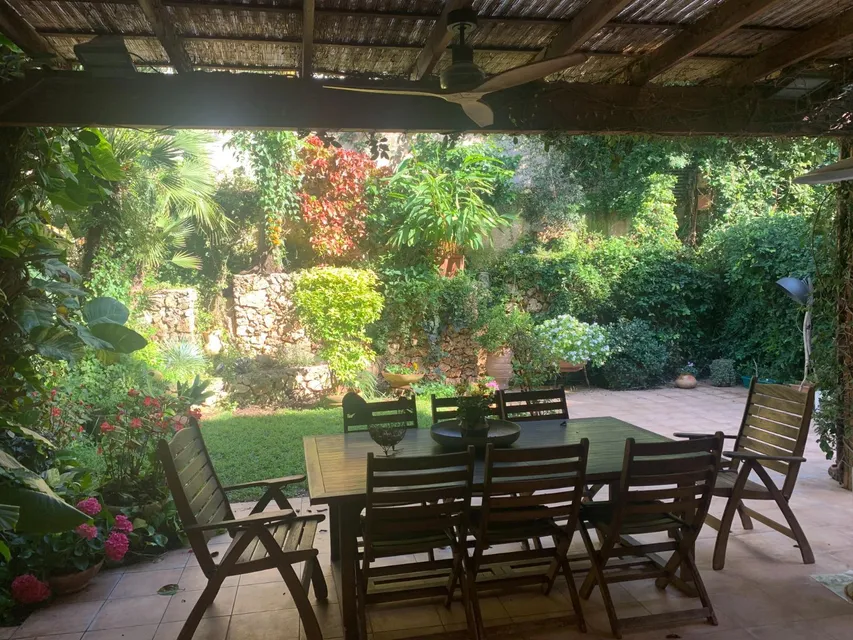

In [ ]:
from PIL import Image
import requests
from io import BytesIO

#image for example
response = requests.get(df_images.iloc[0]["image_url"])
img = Image.open(BytesIO(response.content))
img

##### Insights df: insights about location

In [ ]:
df_insights = createInsightsTable(json_file)
df_insights.head()

,id,insight_category,insight_value,insight_values
0,gBxSkU3fU6h,livability,NaN,"בילויים, קניות וסידורים במרחק הליכה קצרה"
1,gBxSkU3fU6h,nuisances,NaN,הקמת המטרו תגרום למטרדי בנייה באזור
2,gBxSkU3fU6h,planning,NaN,רובע עירוני חדש יקום בפי גלילות
3,gBxSkU3fU6h,transportation,NaN,גשר מתוכנן יקשר לאזורי חן ולים
4,gBxSkU3fU6h,transportation,NaN,צפוי שיפור בשבילי האופניים באזור


### Exporting the dataframes to csv

In [ ]:
df_main.to_csv(r"madlan_apartments.csv",encoding="utf-8_sig",index=False)
df_images.to_csv(r"madlan_images.csv",encoding="utf-8_sig",index=False)
df_tags.to_csv(r"madlan_tags.csv",encoding="utf-8_sig",index=False)
df_insights.to_csv(r"madlan_insights.csv",encoding="utf-8_sig",index=False)